In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import scipy.ndimage as ndi
from skimage import io, color, img_as_ubyte
import ipywidgets as widgets
import io
from PIL import Image

In [2]:
upload = widgets.FileUpload()
upload

FileUpload(value={}, description='Upload')

Shape : (630, 630)
Type : uint8
Min, Max : 0, 255


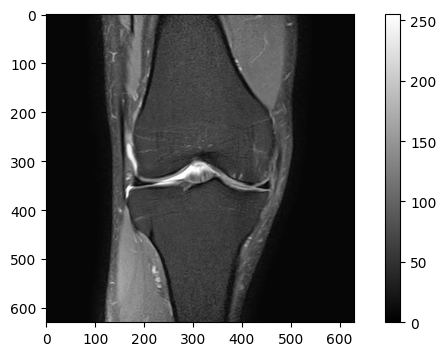

In [3]:
for name, file_info in upload.value.items():
    image = img_as_ubyte(Image.open(io.BytesIO(file_info['content'])))

# plot
plt.figure(figsize = (8,4))
plt.imshow(image, cmap='gray');
plt.colorbar()

# image information
print('Shape :', image.shape)
print('Type :', image.dtype)
print('Min, Max : {}, {}'.format(image.min(), image.max()))

## Image Enhancement

In [4]:
def SaltAndPaper(image, density):
    # create an empty array with same size as input image
    output = np.zeros(image.shape, np.uint8)
    # parameter for controlling how much salt and paper are added
    threshhold = 1 - density
    # loop every each pixel and decide add the noise or not base on threshhold (density)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            possibility = random.random()
            if possibility < density:
                output[i][j] = 0
            elif possibility > threshhold:
                output[i][j] = 255
            else:
               output[i][j] = image[i][j]
    return output

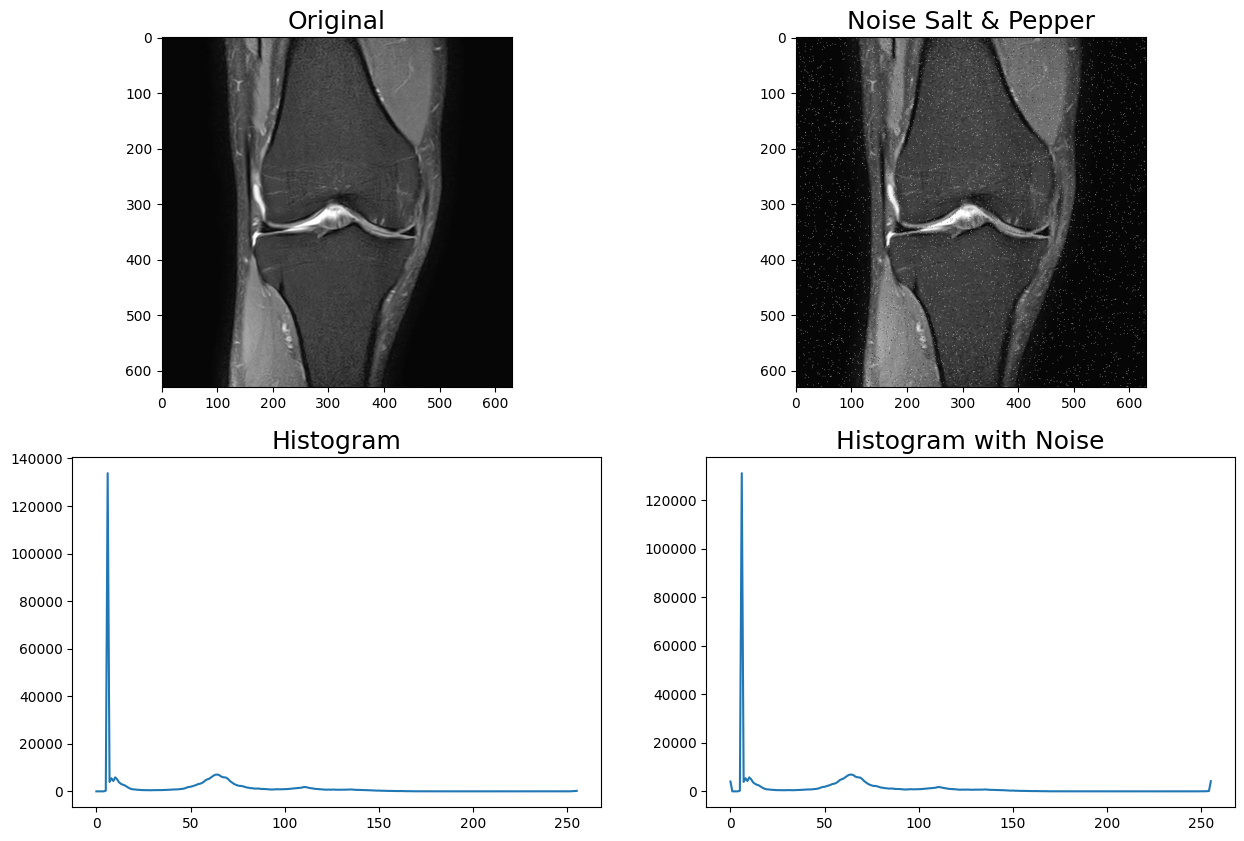

In [5]:
import scipy.ndimage as ndi
from skimage import exposure
from skimage import img_as_ubyte
from skimage.util import random_noise

# Add noise salt and paper (0.01 is a proper parameter)
noise_image = SaltAndPaper(image, 0.01)
#noise_image = random_noise(image,mode='s&p',amount=0.01)
hist_noiseimage = ndi.histogram(noise_image, min=0, max=255, bins=256)

# Adaptive Histogram Equalization
#img_adapt = exposure.equalize_adapthist(noise_image, clip_limit=0.03)
#img_adapt = exposure.equalize_adapthist(image, clip_limit=0.03)
#img_adapteq = img_as_ubyte(img_adapt)  #convert to uint8

#-------CEK AHE---------
#print('Shape :', img_adapteq.shape)
#print('Type :', img_adapteq.dtype)
#print('Min, Max : {}, {}'.format(img_adapteq.min(), img_adapteq.max()))

# HISTOGRAM
hist_image = ndi.histogram(image, min=0, max=255, bins=256)
#hist_img_adapteq = ndi.histogram(img_adapteq, min=0, max=255, bins=256)

#-------PLOT---------#
fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes[0,0].imshow(image, cmap = 'gray')
axes[0,0].set_title('Original', fontsize=18)
axes[0,1].imshow(noise_image, cmap='gray')
axes[0,1].set_title('Noise Salt & Pepper', fontsize=18)
#axes[0,2].imshow(img_adapteq, cmap='gray')
#axes[0,2].set_title('AHE', fontsize=18)

axes[1,0].plot(hist_image)
axes[1,0].set_title('Histogram', fontsize=18)
axes[1,1].plot(hist_noiseimage)
axes[1,1].set_title('Histogram with Noise', fontsize=18);
#axes[1,2].plot(hist_img_adapteq)
#axes[1,2].set_title('Histogram AHE', fontsize=18);

In [6]:
def median_filter(data, filter_size):
    temp = []
    indexer = filter_size // 2
    data_final = []
    data_final = np.zeros((len(data),len(data[0])))
    for i in range(len(data)):
        for j in range(len(data[0])):
            for z in range(filter_size):
                if i + z - indexer < 0 or i + z - indexer > len(data) - 1:
                    for c in range(filter_size):
                        temp.append(0)
                else:
                    if j + z - indexer < 0 or j + indexer > len(data[0]) - 1:
                        temp.append(0)
                    else:
                        for k in range(filter_size):
                            temp.append(data[i + z - indexer][j + k - indexer])
            temp.sort()
            data_final[i][j] = temp[len(temp) // 2]
            temp = []
    return data_final

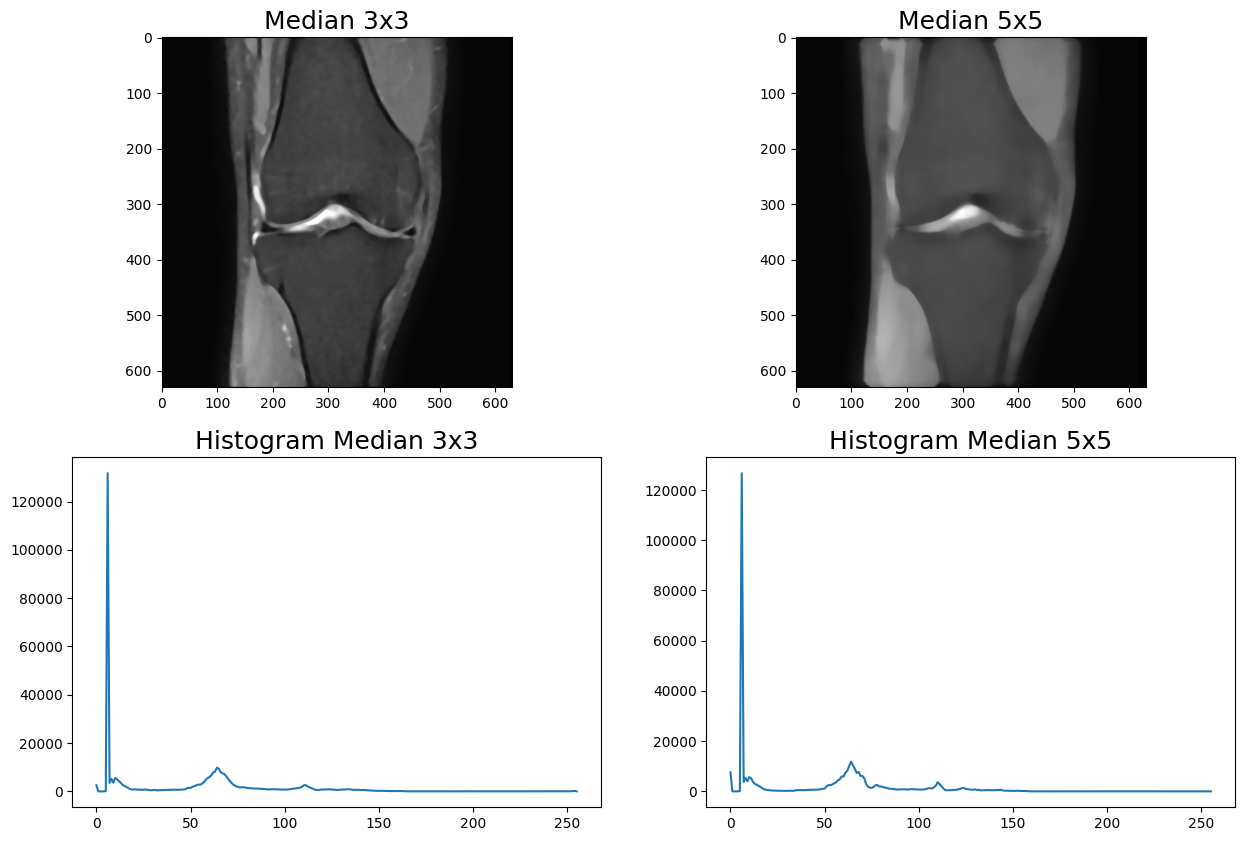

In [7]:
# use 3x3 median filter
median_3x3_image = median_filter(noise_image, 9)
#median_3x3_image = median_filter(img_adapteq, 9)
hist_median3x3 = ndi.histogram(median_3x3_image, min=0, max=255, bins=256)

# use 5x5 median filter
median_5x5_image = median_filter(noise_image, 25)
#median_5x5_image = median_filter(img_adapteq, 25)
hist_median5x5 = ndi.histogram(median_5x5_image, min=0, max=255, bins=256)

#-------PLOT---------#
fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes[0,0].imshow(median_3x3_image, cmap = 'gray')
axes[0,0].set_title('Median 3x3', fontsize=18)
axes[0,1].imshow(median_5x5_image, cmap='gray')
axes[0,1].set_title('Median 5x5', fontsize=18)

axes[1,0].plot(hist_median3x3)
axes[1,0].set_title('Histogram Median 3x3', fontsize=18)
axes[1,1].plot(hist_median5x5)
axes[1,1].set_title('Histogram Median 5x5', fontsize=18);

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def convolution(image, kernel, average=False, verbose=False):
    if len(image.shape) == 3:
        print("Found 3 Channels : {}".format(image.shape))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Converted to Gray Channel. Size : {}".format(image.shape))
    else:
        print("Image Shape : {}".format(image.shape))
    print("Kernel Shape : {}".format(kernel.shape))

    if verbose:
        plt.imshow(image, cmap='gray')
        plt.title("Image")
        plt.show()

    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape

    output = np.zeros(image.shape)

    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)
    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image

    if verbose:
        plt.imshow(padded_image, cmap='gray')
        plt.title("Padded Image")
        plt.show()

    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]
    print("Output Image size : {}".format(output.shape))

    if verbose:
        hist_gaussian = ndi.histogram(output, min=0, max=255, bins=256)
        fig, axes = plt.subplots(1, 2, figsize=(12,5))
        axes[0].imshow(output, cmap = 'gray')
        axes[0].set_title("Output Image using {}X{} Kernel".format(kernel_row, kernel_col))
        axes[1].plot(hist_gaussian)
        axes[1].set_title("Output Histogram {}X{} Kernel".format(kernel_row, kernel_col))
        plt.show()

    return output

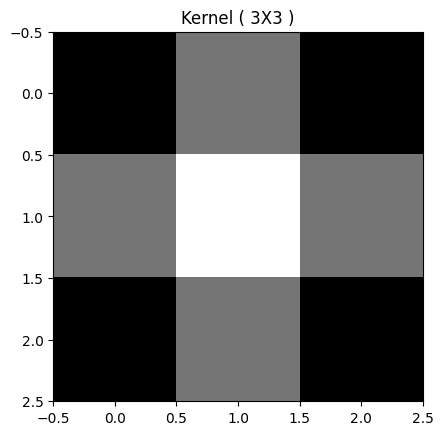

Image Shape : (630, 630)
Kernel Shape : (3, 3)


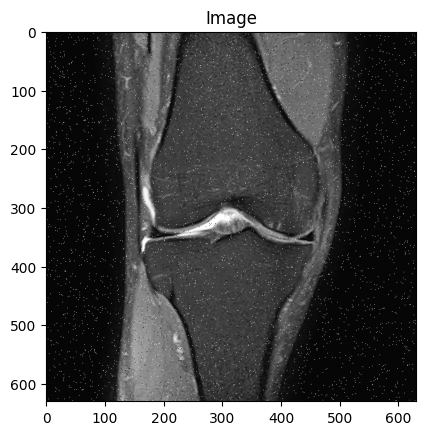

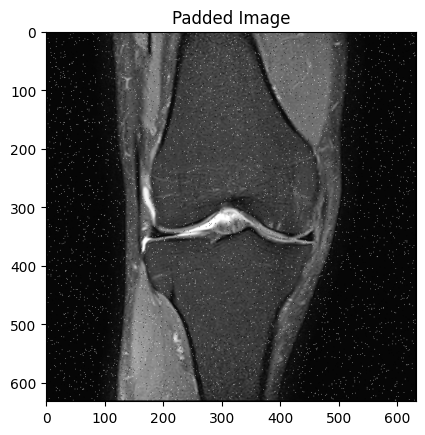

Output Image size : (630, 630)


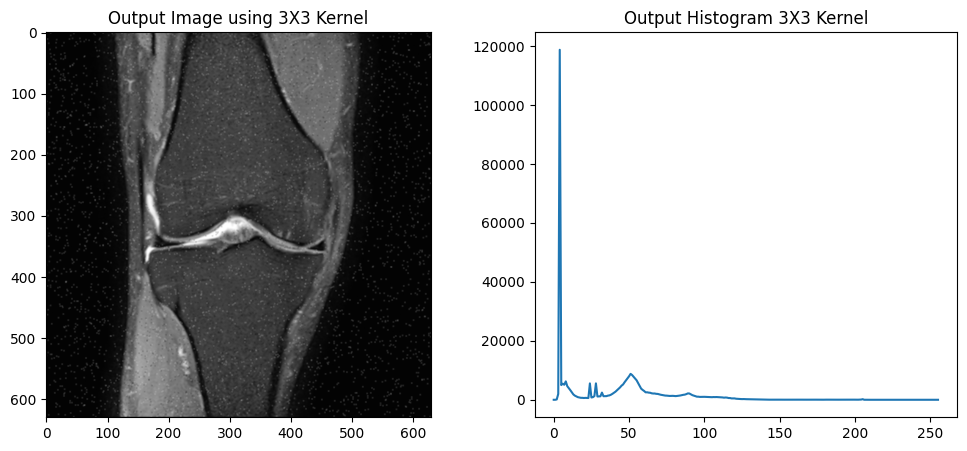

In [9]:
import math

def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)

def gaussian_kernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
    kernel_2D *= 1.0 / kernel_2D.max()

    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Kernel ( {}X{} )".format(size, size))
        plt.show()
    return kernel_2D

def gaussian_blur(image, kernel_size, verbose=False):
    kernel = gaussian_kernel(kernel_size, sigma=math.sqrt(kernel_size), verbose=verbose)
    return convolution(image, kernel, average=True, verbose=verbose)

if __name__ == '__main__':
    gaussian_blur(noise_image, 3, verbose=True)

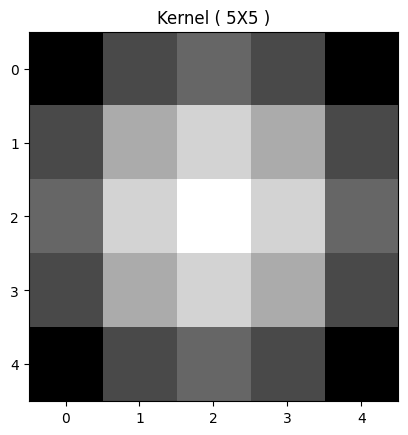

Image Shape : (630, 630)
Kernel Shape : (5, 5)


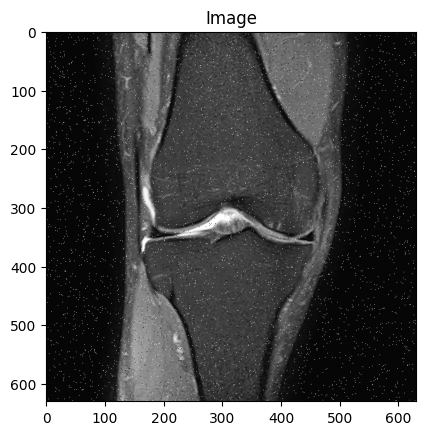

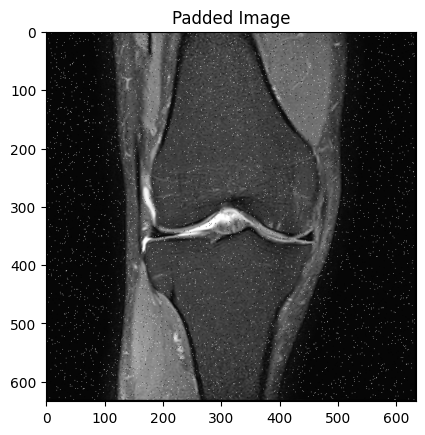

Output Image size : (630, 630)


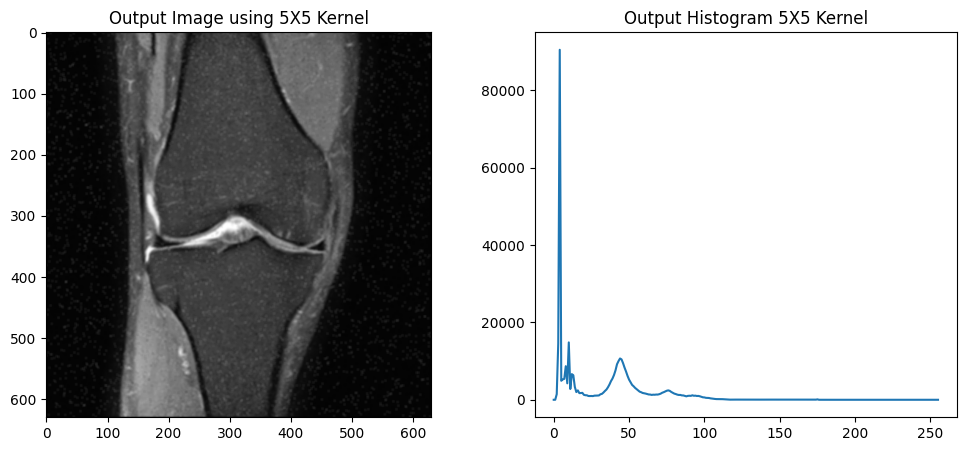

In [10]:
if __name__ == '__main__':
    gaussian_blur(noise_image, 5, verbose=True)

MSE + PSNR

In [11]:
#GAMBAR FILTER = MEDIAN 3x3
filtered_image = median_3x3_image
def MSE (image,filtered_image) :
    M,N = image.shape
    mse = 0
    for m in range (M):
        for n in range (N):
            mse+=(filtered_image[m,n]-image[m,n])**2/(M*N)
        return mse
mse_max1 = MSE(filtered_image,image)
psnr_max1 = 10*np.log10(255**2/mse_max1)

print("MSE value :" +str(mse_max1))
print('PSNR value :' +str(psnr_max1))

MSE value :0.36507936507936556
PSNR value :52.50693074303898


## Edge Detection

array([[-1],
       [ 0],
       [ 1]])

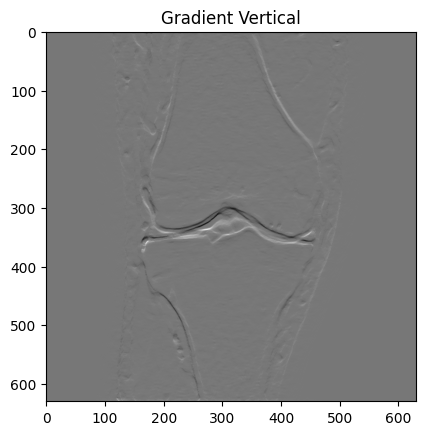

In [12]:
#GAMBAR FILTER = MEDIAN 3x3
filtered_image = median_3x3_image

#Gradient Vertical
ver_ken = np.array([[-1],[0],[1]])
grad_ver = ndi.convolve(filtered_image, ver_ken)

fig, ax = plt.subplots()
ax.imshow(grad_ver, cmap='gray')
ax.set_title('Gradient Vertical')
ver_ken

array([[-1,  0,  1]])

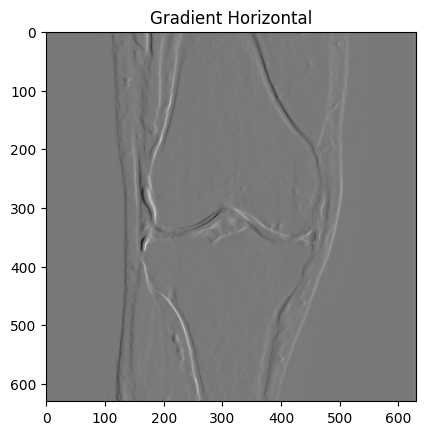

In [13]:
#Gradient Horizontal
hor_ken = ver_ken.T
grad_hor = ndi.convolve(filtered_image, hor_ken)

fig, ax = plt.subplots()
ax.imshow(grad_hor, cmap='gray')
ax.set_title('Gradient Horizontal')
hor_ken

In [14]:
#Gradient Magnitude
grad_mag = np.sqrt(grad_ver**2 + grad_hor**2)
print('dtype : ', grad_mag.dtype)
print('Min, Max : {}, {}'.format(grad_mag.min(), grad_mag.max()))
grad_mag

dtype :  float64
Min, Max : 0.0, 142.57980221616245


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [6.        , 6.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [6.        , 8.48528137, 8.48528137, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 6.        , ..., 0.        , 0.        ,
        0.        ]])

dtype :  float64
Min, Max : 0.0, 1.0
dtype :  uint8


Text(0.5, 1.0, 'Gradient Magnitude')

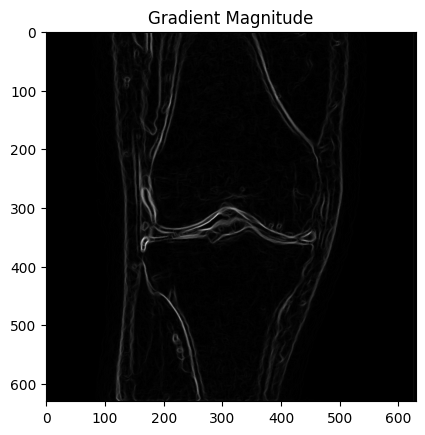

In [15]:
#membenarkan clipping
image_eq = grad_mag/np.amax(grad_mag)
image_eq = np.clip(image_eq, 0, 255)
print('dtype : ', image_eq.dtype)
print('Min, Max : {}, {}'.format(image_eq.min(), image_eq.max()))

from skimage import img_as_ubyte
grad_mag2 = img_as_ubyte(image_eq)
print('dtype : ', grad_mag2.dtype)

fig, ax = plt.subplots()
ax.imshow(grad_mag2, cmap='gray')
ax.set_title('Gradient Magnitude')

### Sobel Filter

dtype :  float64
dtype mag sobel :  float64
Min, Max : 0.0, 505.9169892383532
dtype :  float64
Min, Max : 0.0, 1.0
dtype :  uint8


Text(0.5, 1.0, 'Sobel Filter')

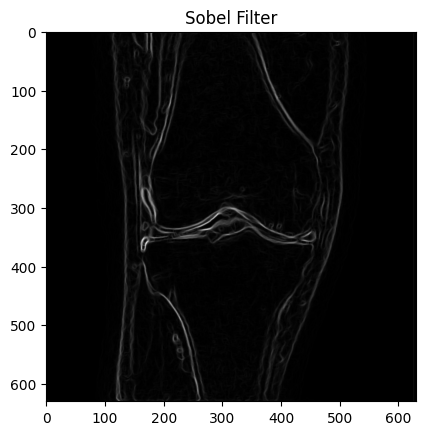

In [16]:
sobel_ax0 = ndi.sobel(filtered_image, axis=0) #horizontal
sobel_ax1 = ndi.sobel(filtered_image, axis=1) #vertical
edges = np.sqrt(sobel_ax0**2 + sobel_ax1**2)

print('dtype : ', sobel_ax0.dtype)
print('dtype mag sobel : ', edges.dtype)
print('Min, Max : {}, {}'.format(edges.min(), edges.max()))

#membenarkan clipping
edges_eq = edges/np.amax(edges)
edges_eq = np.clip(edges_eq, 0, 255)
print('dtype : ', edges_eq.dtype)
print('Min, Max : {}, {}'.format(edges_eq.min(), edges_eq.max()))

from skimage import img_as_ubyte
edges2 = img_as_ubyte(edges_eq)
print('dtype : ', edges2.dtype)

fig, ax = plt.subplots()
ax.imshow(edges2, cmap='gray')
ax.set_title('Sobel Filter')

## Masking

Text(0.5, 1.0, 'Histogram Filtered Image')

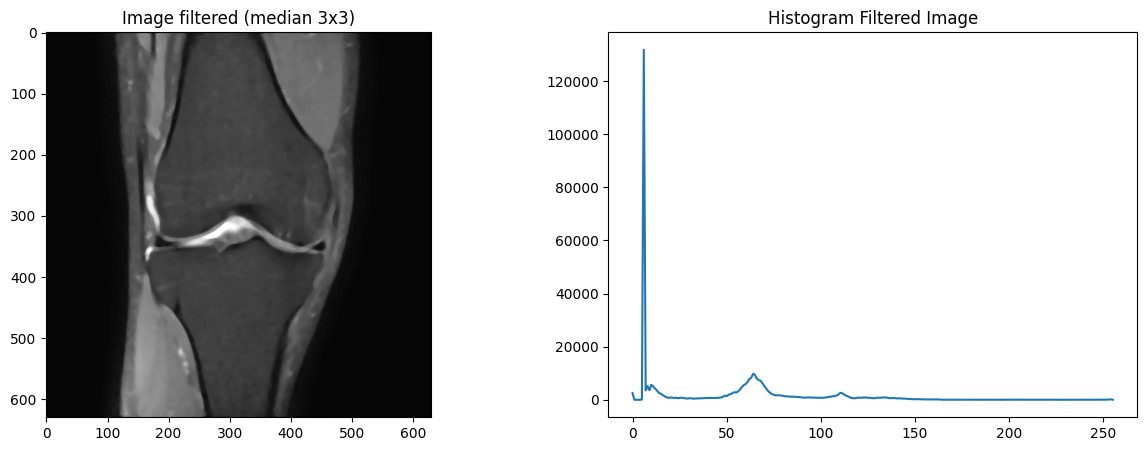

In [17]:
filtered_hist = ndi.histogram(filtered_image, min=0, max=255, bins=256)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(filtered_image, cmap = 'gray')
axes[0].set_title('Image filtered (median 3x3)')
axes[1].plot(filtered_hist)
axes[1].set_title('Histogram Filtered Image')

Shape : (630, 310)
Type : float64
Min, Max : 5.0, 254.0


Text(0.5, 1.0, 'Histogram Cut Image')

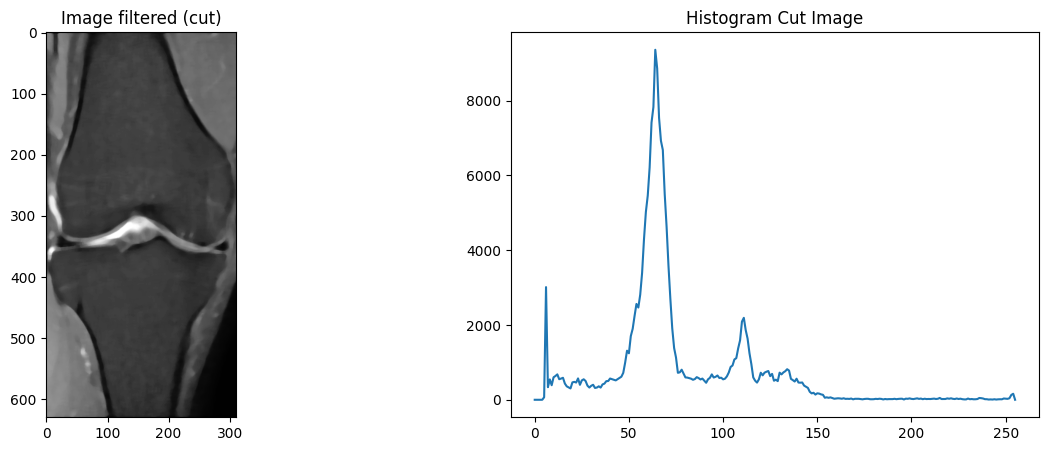

In [18]:
image_cut = filtered_image[0:630,160:470]      # [up:down , left:right]
hist_cutimage = ndi.histogram(image_cut, min=0, max=255, bins=256)

print('Shape :', image_cut.shape)
print('Type :', image_cut.dtype)
print('Min, Max : {}, {}'.format(image_cut.min(), image_cut.max()))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(image_cut, cmap = 'gray')
axes[0].set_title('Image filtered (cut)')
axes[1].plot(hist_cutimage)
axes[1].set_title('Histogram Cut Image')

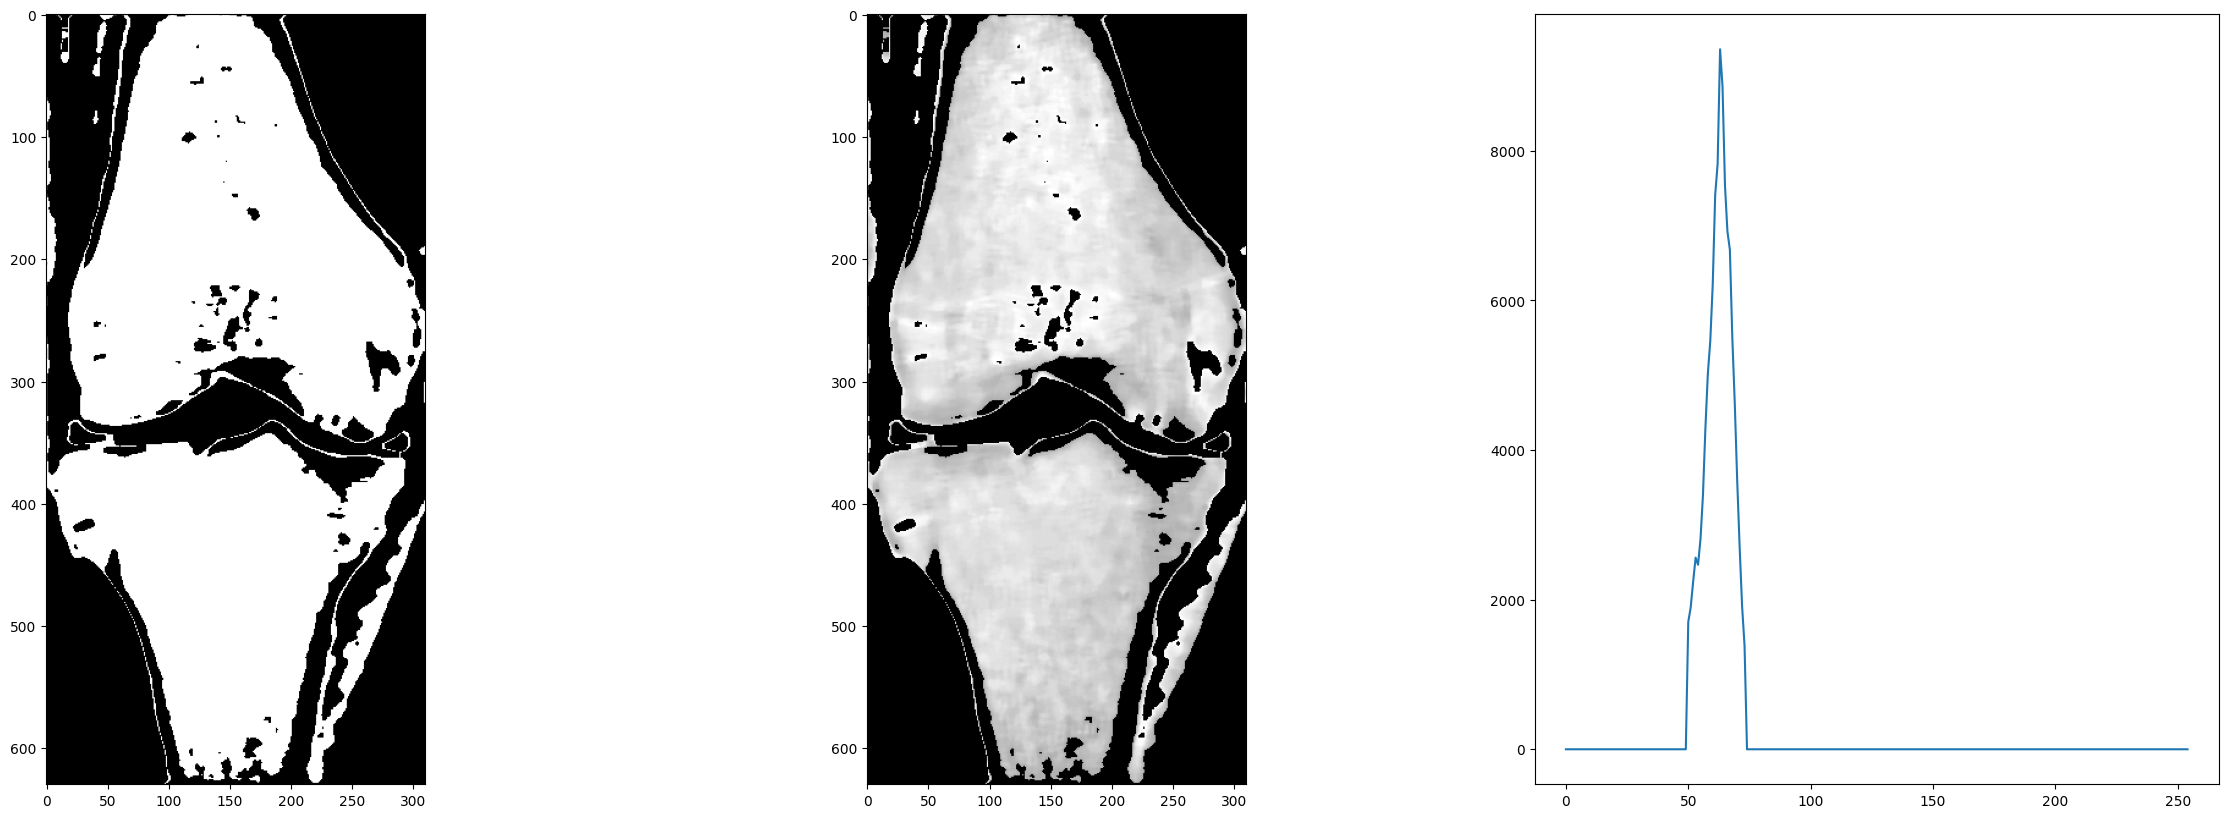

In [19]:
mask_knee = (image_cut > 50) & (image_cut < 75)
mask_knee = mask_knee*1 #dikali satu utk convert "true-false" to "1-0"
im_knee = np.where(mask_knee, image_cut, 0)

hist_imknee = ndi.histogram(im_knee, min=1, max=255, bins=255)

fig,axes = plt.subplots(1, 3, figsize=(30,10))
axes[0].imshow(mask_knee, cmap='gray')
axes[1].imshow(im_knee, cmap='gray')
axes[2].plot(hist_imknee)
plt.show()

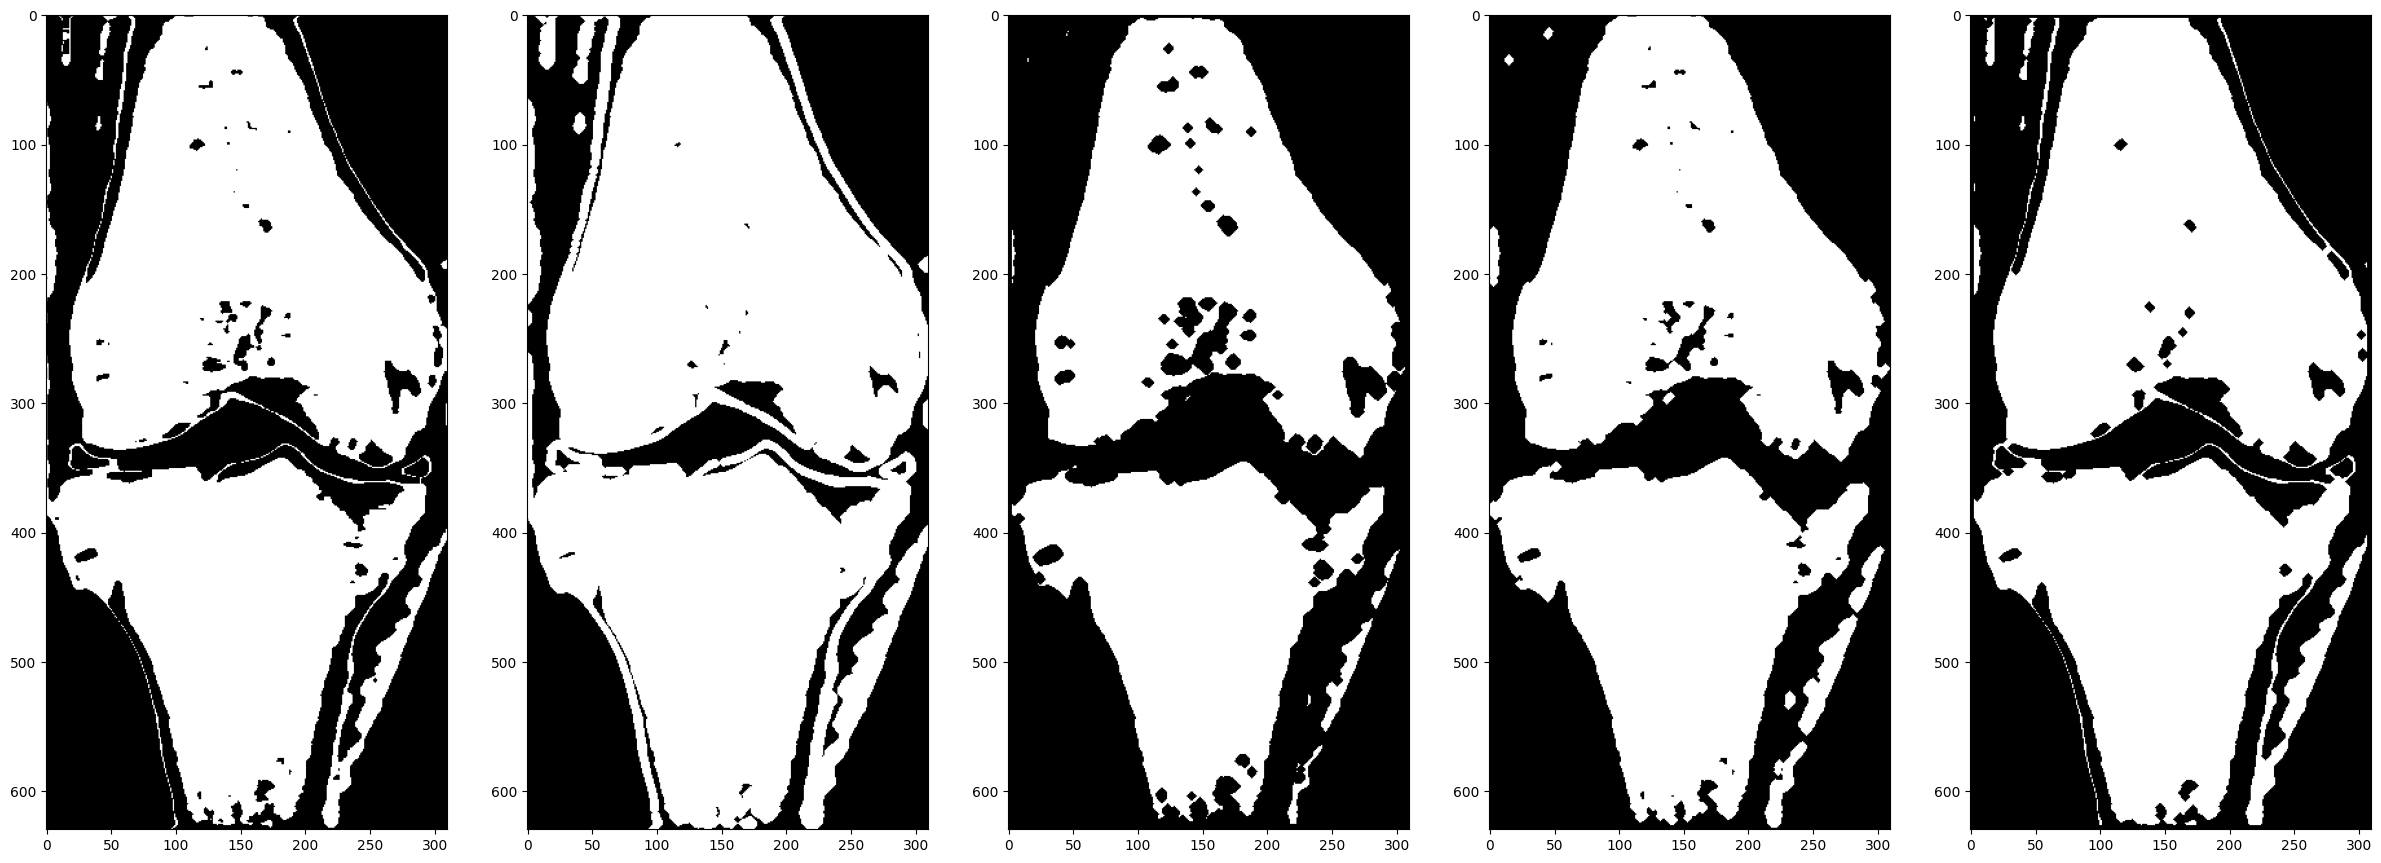

In [20]:
# Tune mask
# mask_knee = np.where(image_cut < 55, 1, 0)  #cara lain
mask_dilate = ndi.binary_dilation(mask_knee, iterations=3)
mask_erose = ndi.binary_erosion(mask_knee, iterations=3)
mask_opened = ndi.binary_opening(mask_knee, iterations=3)
mask_closed = ndi.binary_closing(mask_knee, iterations=3)

fig, axes = plt.subplots(1, 5, figsize=(30,20))
axes[0].imshow(mask_knee, cmap='gray')
axes[1].imshow(mask_dilate, cmap='gray')
axes[2].imshow(mask_erose, cmap='gray')
axes[3].imshow(mask_opened, cmap='gray')
axes[4].imshow(mask_closed, cmap='gray')

## Segmentation and Labelling

In [21]:
from skimage import filters
threshold = filters.threshold_otsu(im_knee)
threshold

0.14453125

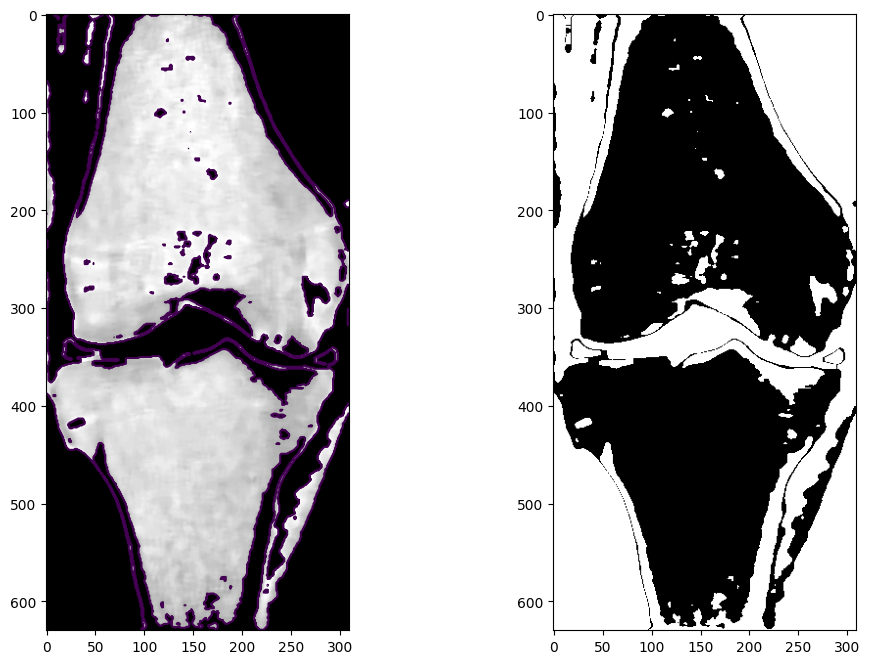

In [22]:
fig,axes = plt.subplots(1,2, figsize=(12, 8))
axes[0].imshow(im_knee, cmap='gray')
axes[0].contour(im_knee, [threshold]) #contour pada daerah threshold
axes[1].imshow(im_knee < threshold, cmap='gray')

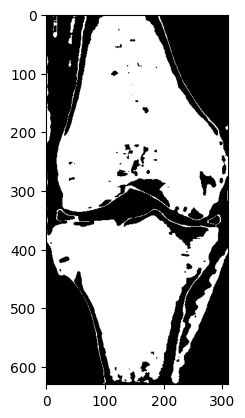

In [23]:
binary_image = im_knee > filters.threshold_otsu(im_knee)
plt.imshow(binary_image, cmap='gray')

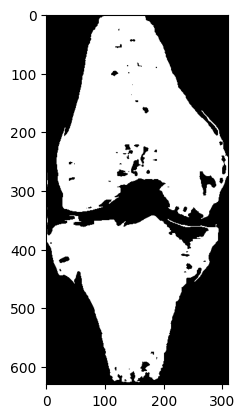

In [24]:
from skimage import morphology

#Remove small objects
only_large = morphology.remove_small_objects(binary_image, min_size=40000)
plt.imshow(only_large, cmap='gray')

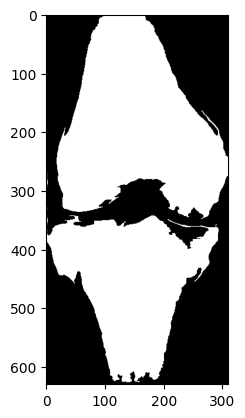

In [25]:
#Fill small holes
image_segmented = np.logical_not(morphology.remove_small_objects(np.logical_not(only_large),
                                                                 min_size=15000))
plt.imshow(image_segmented, cmap='gray')

In [26]:
labels, nlabels = ndi.label(image_segmented)

label_arrays = []
print('There are {} separate components / objects detected.'.format(nlabels))

There are 2 separate components / objects detected.


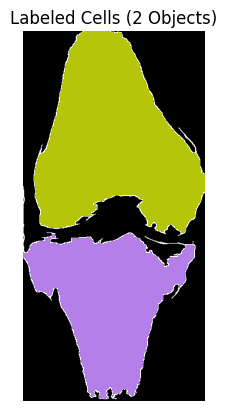

In [27]:
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(image_segmented, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Objects)'.format(nlabels))
plt.show()

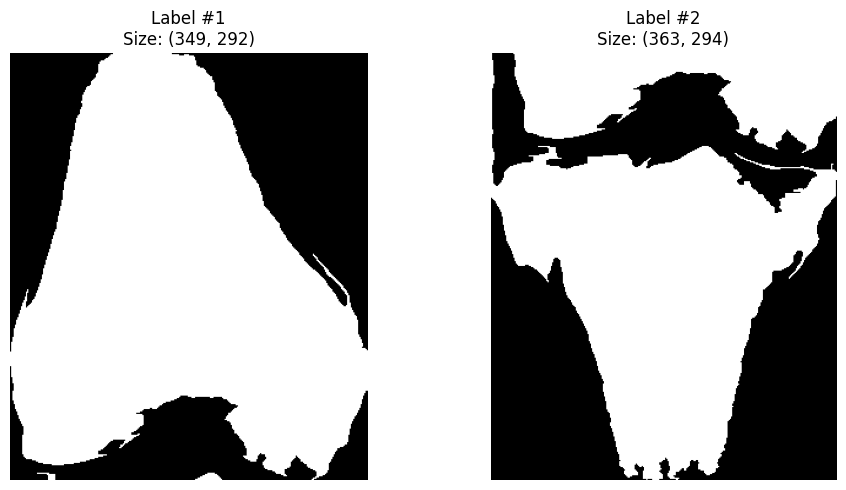

In [28]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
for ii, obj_indices in enumerate(ndi.find_objects(labels)):
    cell = image_segmented[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))
plt.tight_layout()
plt.show()

In [29]:
import math
import pandas as pd
from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate

label_img = label(image_segmented)
regions = regionprops(label_img)
label_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

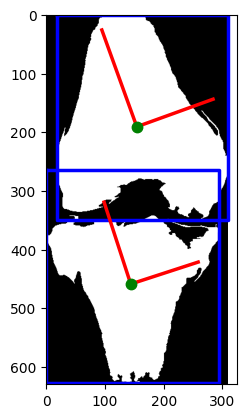

In [30]:
fig, ax = plt.subplots()
ax.imshow(image_segmented, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)
plt.show()

In [31]:
props = regionprops_table(label_img, properties=('centroid',
                                                 'orientation',
                                                 'major_axis_length',
                                                 'minor_axis_length'))

df1=pd.DataFrame(props)
df1

,centroid-0,centroid-1,orientation,major_axis_length,minor_axis_length
0,190.509386,154.093568,0.346573,350.691137,276.416729
1,458.621370,143.764271,0.314643,293.618408,241.770050
